Running on: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.21MB/s]



Starting Training...
Epoch [1/20] | Average Loss: 192.5183
Epoch [2/20] | Average Loss: 166.6381
Epoch [3/20] | Average Loss: 161.2880
Epoch [4/20] | Average Loss: 158.1294
Epoch [5/20] | Average Loss: 155.7521
Epoch [6/20] | Average Loss: 153.8076
Epoch [7/20] | Average Loss: 152.3634
Epoch [8/20] | Average Loss: 151.1878
Epoch [9/20] | Average Loss: 150.0536
Epoch [10/20] | Average Loss: 149.0010
Epoch [11/20] | Average Loss: 148.0253
Epoch [12/20] | Average Loss: 147.3100
Epoch [13/20] | Average Loss: 146.6102
Epoch [14/20] | Average Loss: 145.9218
Epoch [15/20] | Average Loss: 145.3213
Epoch [16/20] | Average Loss: 144.8571
Epoch [17/20] | Average Loss: 144.3902
Epoch [18/20] | Average Loss: 143.9641
Epoch [19/20] | Average Loss: 143.6380
Epoch [20/20] | Average Loss: 143.2383


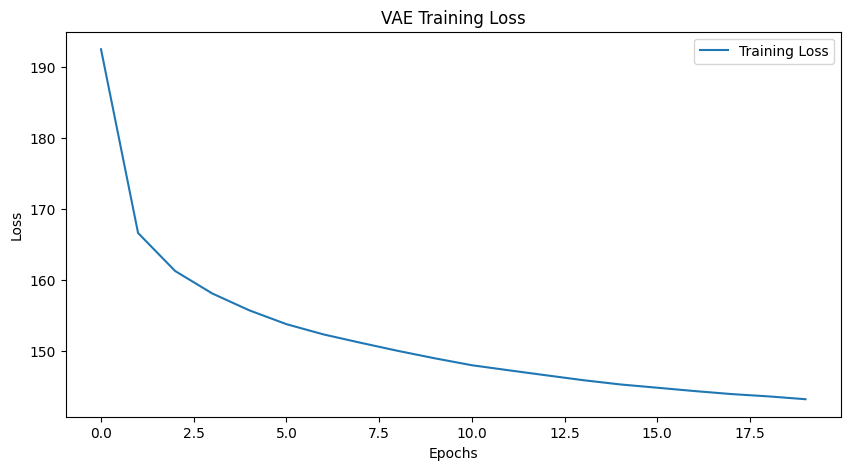

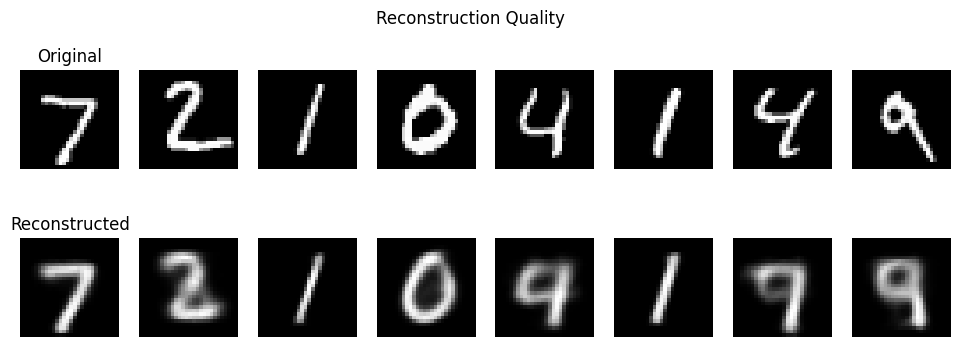


Generating new samples from latent space...


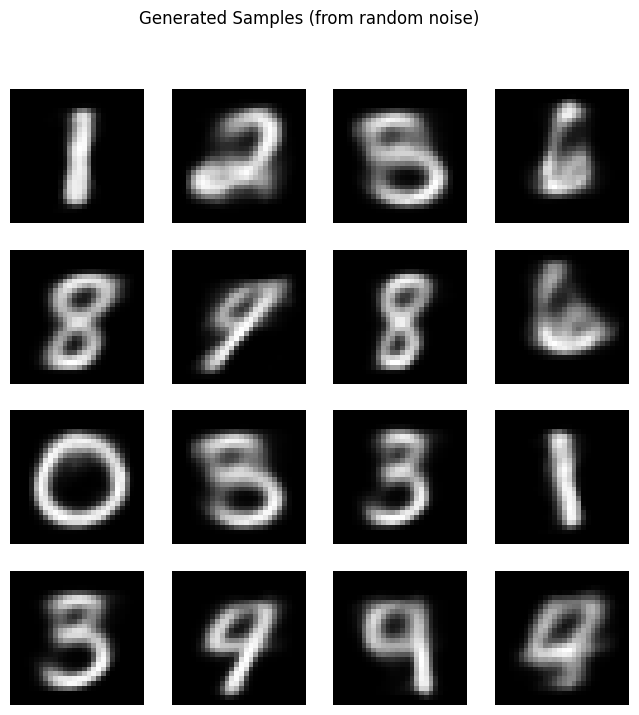

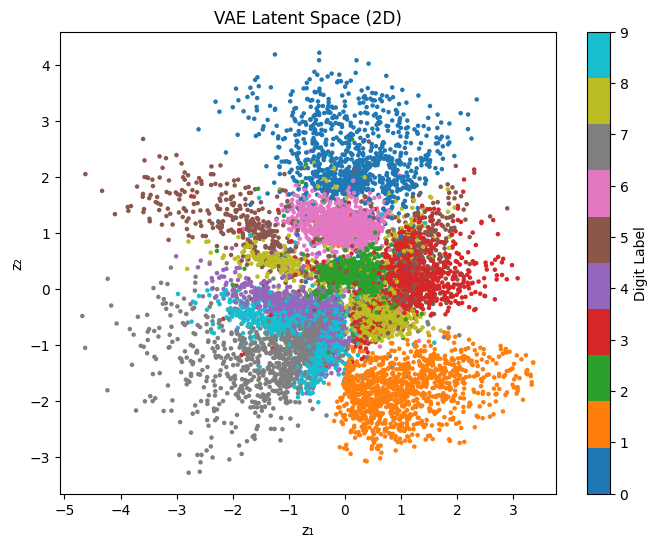

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Configuration & Hardware Setup ---
# Checks for your RTX 3060 (CUDA)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {DEVICE}")

# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0002
EPOCHS = 20
LATENT_DIM = 2  # Set to 2 for easier visualization (Task 6)

# --- Task 1: Dataset Preparation (MNIST) ---
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load MNIST
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Task 2: Build the VAE Architecture ---
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        # 1. Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # Latent distribution parameters (Mean and Log-Variance)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # 2. Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid() # Output pixels between 0 and 1
        )

    def reparameterize(self, mu, logvar):
        """
        The Reparameterization Trick:
        z = mu + std * epsilon
        Allows backpropagation through the stochastic node.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std) # Sample from standard normal
        return mu + eps * std

    def forward(self, x):
        # Flatten image
        x = x.view(-1, 28*28)

        # Encode
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        reconstruction = self.decoder(z)
        return reconstruction, mu, logvar

# Initialize Model and move to GPU
model = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Task 3: Define Loss Function ---
def loss_function(recon_x, x, mu, logvar):
    # 1. Reconstruction Loss (Binary Cross Entropy)
    # Compares the original image with the reconstructed image
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # 2. KL Divergence Loss
    # Measures how much the learned latent distribution deviates from a standard normal distribution
    # Formula: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# --- Task 4: Train the VAE ---
print("\nStarting Training...")
train_loss_history = []

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to GPU
        data = data.to(DEVICE)

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    train_loss_history.append(avg_loss)
    print(f'Epoch [{epoch+1}/{EPOCHS}] | Average Loss: {avg_loss:.4f}')

# --- Task 5: Sample Generation & Visualization ---
def visualize_results(model, test_loader):
    model.eval()

    # 1. Plot Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_history, label='Training Loss')
    plt.title("VAE Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # 2. Reconstruct Test Images
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(DEVICE)
        recon, _, _ = model(data)

        # Move back to CPU for plotting
        data = data.cpu()
        recon = recon.view(-1, 1, 28, 28).cpu()

        fig, axes = plt.subplots(2, 8, figsize=(12, 4))
        for i in range(8):
            # Original
            axes[0, i].imshow(data[i][0], cmap='gray')
            axes[0, i].axis('off')
            if i == 0: axes[0, i].set_title("Original")

            # Reconstructed
            axes[1, i].imshow(recon[i][0], cmap='gray')
            axes[1, i].axis('off')
            if i == 0: axes[1, i].set_title("Reconstructed")
        plt.suptitle("Reconstruction Quality")
        plt.show()

    # 3. Generate New Samples from Latent Space
    print("\nGenerating new samples from latent space...")
    with torch.no_grad():
        # Sample random vectors from standard normal distribution (z ~ N(0, 1))
        z = torch.randn(64, LATENT_DIM).to(DEVICE)
        sample = model.decoder(z).cpu()

        plt.figure(figsize=(8, 8))
        # Create a grid of images
        grid_img = sample.view(64, 28, 28)
        for i in range(16): # Show first 16
            plt.subplot(4, 4, i+1)
            plt.imshow(grid_img[i], cmap='gray')
            plt.axis('off')
        plt.suptitle("Generated Samples (from random noise)")
        plt.show()

# Run Visualization
visualize_results(model, test_loader)
def plot_latent_space(model, test_loader):
    model.eval()

    zs = []
    labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(DEVICE)
            data = data.view(-1, 784)

            h = model.encoder(data)
            mu = model.fc_mu(h)

            zs.append(mu.cpu())
            labels.append(target)

    zs = torch.cat(zs)
    labels = torch.cat(labels)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(
        zs[:, 0],
        zs[:, 1],
        c=labels,
        cmap="tab10",
        s=5
    )
    plt.colorbar(scatter, label="Digit Label")
    plt.title("VAE Latent Space (2D)")
    plt.xlabel("z₁")
    plt.ylabel("z₂")
    plt.show()
plot_latent_space(model, test_loader)